# Cancer Diagnosis using Support Vector Machine

## Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

## Data dwonloading
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

 To download the data, we will use `!wget` to download it from IBM Object Storage.

In [2]:
!wget -O cell_samples.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv

--2024-04-23 12:14:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19975 (20K) [text/csv]
Saving to: 'cell_samples.csv'

     0K .......... .........                                  100%  202K=0.1s

2024-04-23 12:14:04 (202 KB/s) - 'cell_samples.csv' saved [19975/19975]



## Load data from CSV and visualization

In [5]:
df = pd.read_csv('cell_samples.csv')
df[0:5]

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [37]:
df['Class'].value_counts()

Class
2    458
4    241
Name: count, dtype: int64

<Axes: >

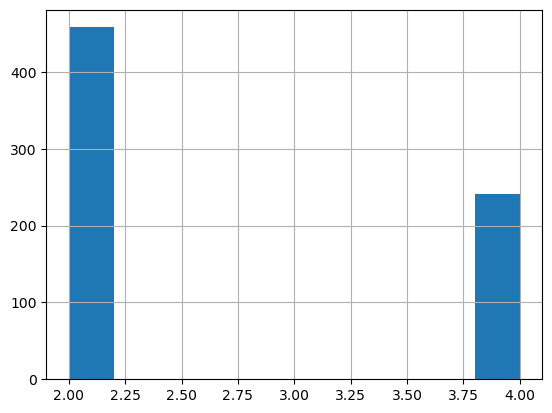

In [13]:
df['Class'].hist()

The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:).

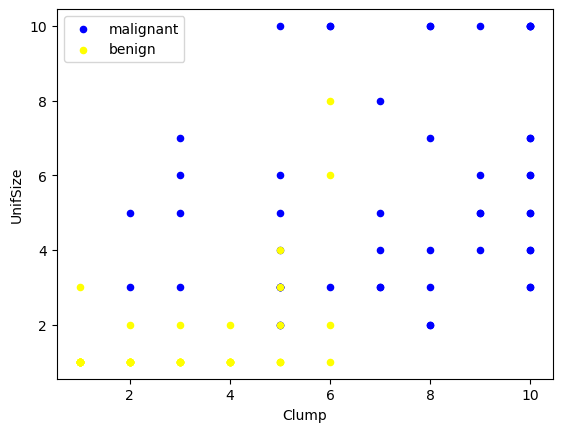

In [6]:
ax = df[df['Class'] == 4][0:50].plot(kind = 'scatter', x = 'Clump', y = 'UnifSize', color = 'blue', label = 'malignant')
df[df['Class'] == 2][0:50].plot(kind = 'scatter', x = 'Clump', y = 'UnifSize', color = 'Yellow', label = 'benign', ax = ax )
plt.show()

## Data pre-processing and selection

Let's first look at columns data types:

In [23]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

As we see the data type of BareNuc column is object!!

In [25]:
print(df['BareNuc'])

0       1
1      10
2       2
3       4
4       1
       ..
694     2
695     1
696     3
697     4
698     5
Name: BareNuc, Length: 699, dtype: object


In [31]:
print(df['BareNuc'].value_counts())

BareNuc
1     402
10    132
2      30
5      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: count, dtype: int64


It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:

In [7]:
df = df[pd.to_numeric(df['BareNuc'], errors = 'coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int64')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
feature_df = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = feature_df.values
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [9]:
Y = df['Class'].values
Y[0:5]

array([2, 2, 2, 2, 2], dtype=int64)

## Train/test dataset

In [26]:
X_train, X_test,Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 4)
print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


## Modeling (SVM with Scikit-learn)

The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```
we choose RBF:

In [29]:
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, Y_train)

SVC()

In [30]:
yhat = clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2], dtype=int64)

## Evaluation

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


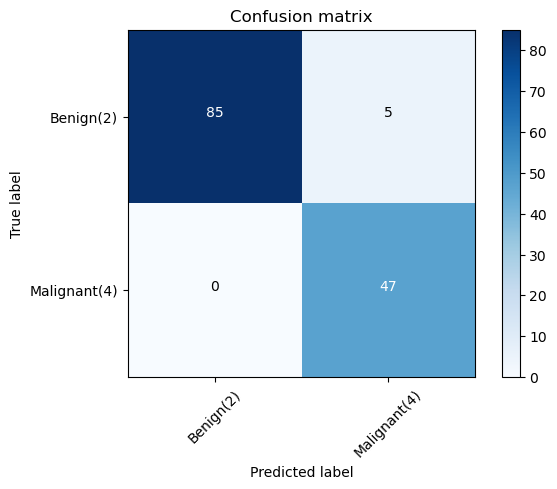

In [55]:
#Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, yhat, labels = [2,4])
np.set_printoptions(precision = 2)
print(classification_report(Y_test, yhat))
#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)', 'Malignant(4)'], normalize = False, title='Confusion matrix')

In [57]:
from sklearn.metrics import f1_score
f1_score(Y_test, yhat, average = 'weighted')

0.9639038982104676

In [56]:
from sklearn.metrics import jaccard_score
jaccard_score(Y_test, yhat, pos_label = 2)

0.9444444444444444